In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations

%matplotlib inline
plt.rcParams["figure.figsize"] = (18, 8)


## 1. Creación del Grafo
A partir del archivo de datos, genere el grafo de colaboraciones entre autores. Cuente el número de
nodos y aristas. Haga una representacion grafica del grafo.

In [35]:
all_authors = set()
author_string_cleaning_table = {ord(c): None for c in " "+"\\"+")"}

def create_graph():
    G = nx.Graph(name="Authors")
    csv = pd.read_csv("data.csv", names=["year", "code", "pub", "authors", "name"])
    for index, author_string in enumerate(csv["authors"]):
        authors = [a.translate(author_string_cleaning_table) for a in author_string.split("&")]
        all_authors.update(authors)
        if len(authors) == 1:
            G.add_nodes_from(authors)
        else:
            comb = combinations(authors, 2)
            G.add_edges_from(comb)
            
    return G

In [36]:
G = create_graph()
print(nx.info(G))

Name: Authors
Type: Graph
Number of nodes: 3994
Number of edges: 7856
Average degree:   3.9339


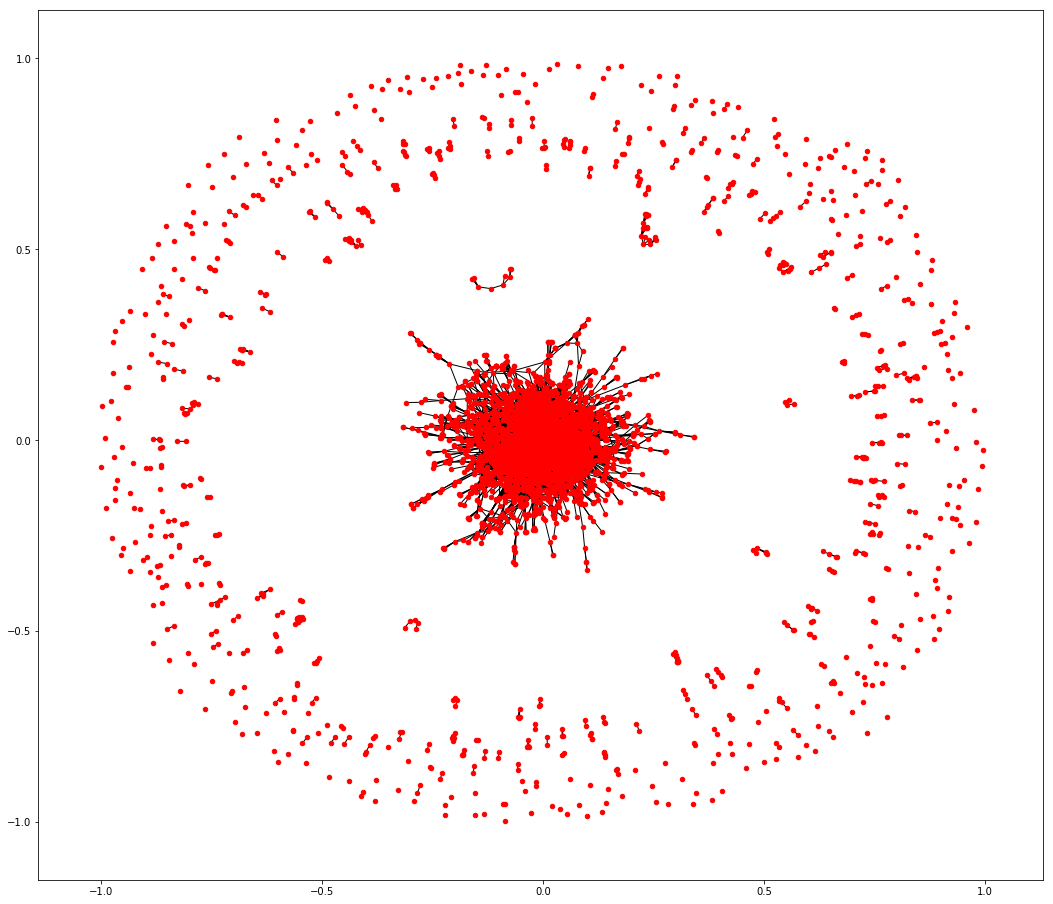

In [37]:
def draw_graph(G):
    plt.figure(figsize=(18, 16))
    nx.draw_networkx(G, node_size=20, with_labels=False)

draw_graph(G)

## 2. Distribución de Grado
Grafique la distribución del grado de los autores, en escalas lineales, semilogarıtmica, y log-log. Argumente, a partir de los graficos, de que tipo de distribucion se trata.

Gráfico de Distribución del Grado de los Autores en Escala Lineal

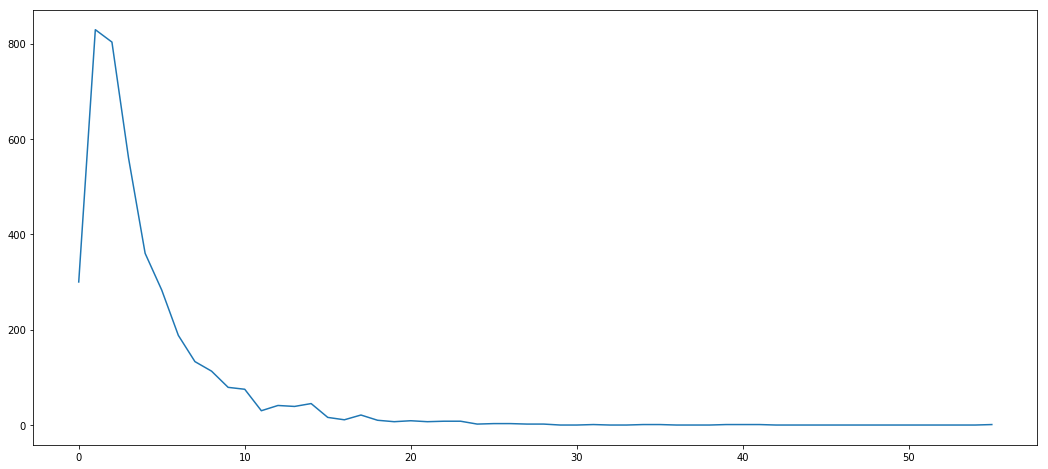

In [38]:
deg_histogram = nx.degree_histogram(G)
plt.plot(deg_histogram)

Mismo gráfico, pero en escala semi-log.

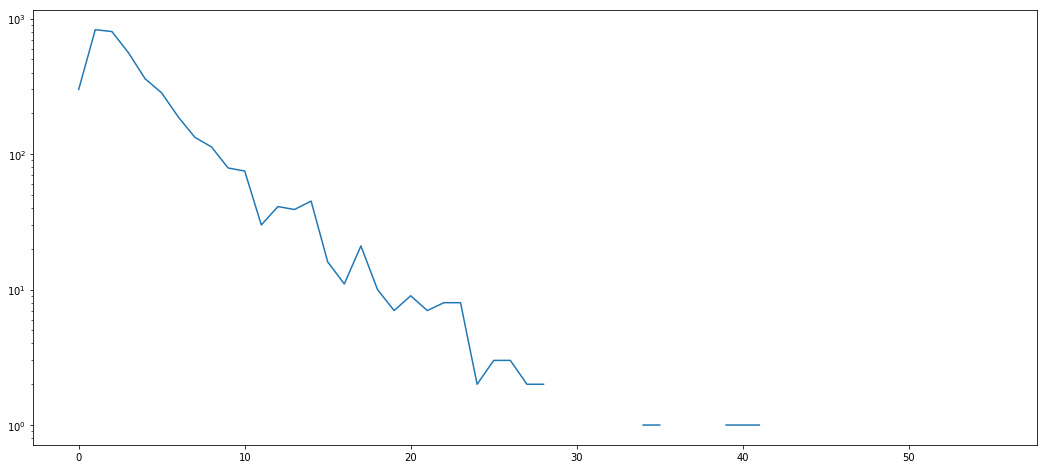

In [39]:
plt.semilogy(deg_histogram)

Mismo gráfico, pero en escala log-log.

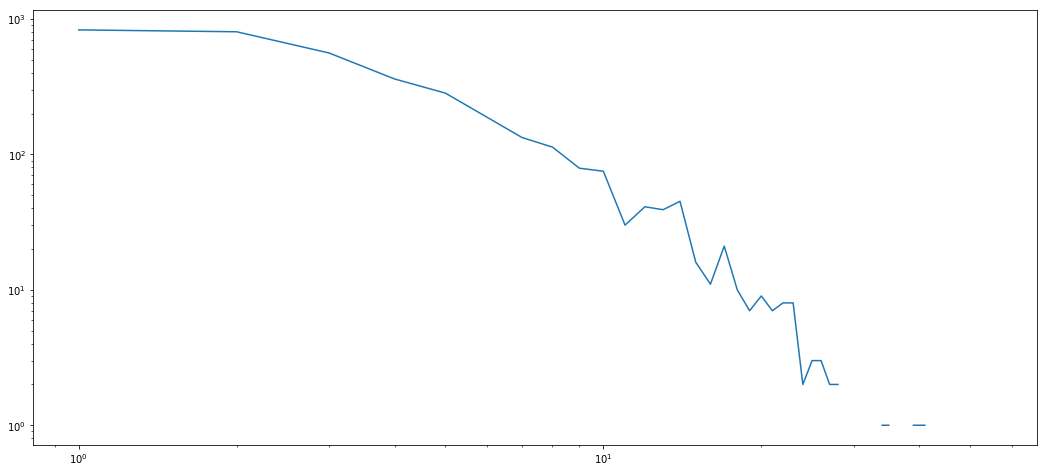

In [40]:
plt.loglog(deg_histogram)

Vista con el eje Y en escala logarítmica parece ser una línea recta, por lo que la distribución parecería ser una exponencial

## 3. Componentes Conexas
Calcule el número de componentes conexas del grafo. Muestre el tamaño de la componente mayor, o componente gigante.

In [41]:
amount_of_connected_components = nx.number_connected_components(G)
print('Cantidad de componentes conexas: {}'.format(amount_of_connected_components))

Cantidad de componentes conexas: 536


Buscamos la componente mayor para mostrar su tamaño.

In [42]:
connected_components = nx.connected_components(G)
biggest_connected_component = max(connected_components, key=len)
print("Tamaño de la componente mayor: {}".format(len(biggest_connected_component)))

Tamaño de la componente mayor: 3014


## 4.Tamaño de Vecindades
Trabajando con la componente gigante del grafo, estudie, parándose en un nodo al azar, cómo aumenta
el número de autores alcanzados a medida que se aleja del nodo semilla. Grafique el número de autores
alcanzados en función de la distancia al nodo semilla. Grafique también el número de nuevos autores
que se agregan en cada paso, y estime el máximo de esta función. Pruebe con varios nodos semillas y
analice la robustez de este resultado. Discuta el significado de los gráficos y su relación con el fenómeno
de seis grados de separación.